/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1.2301 - mae: 1.6839 - val_loss: 0.5686 - val_mae: 1.0185 - learning_rate: 1.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0441 - mae: 1.4815 - val_loss: 0.5486 - val_mae: 0.9773 - learning_rate: 1.0000e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8771 - mae: 1.3105 - val_loss: 0.5354 - val_mae: 0.9515 - learning_rate: 1.0000e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8607 - mae: 1.2518 - val_loss: 0.5259 - val_mae: 0.9308 - learning_rate: 1.0000e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8856 - mae: 1.2971 - val_loss: 0.5180 - val_mae: 0.9027 - learning_rate: 1.0000e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9245 - mae: 1.3620 - val_loss: 0.5135 - val_mae: 0.8896 - learning_rate: 1.0000e-04
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6742 - mae: 1.0621 - val_loss: 0.5097 - val_mae: 0.8798 - learning_rate: 1.0000e-04

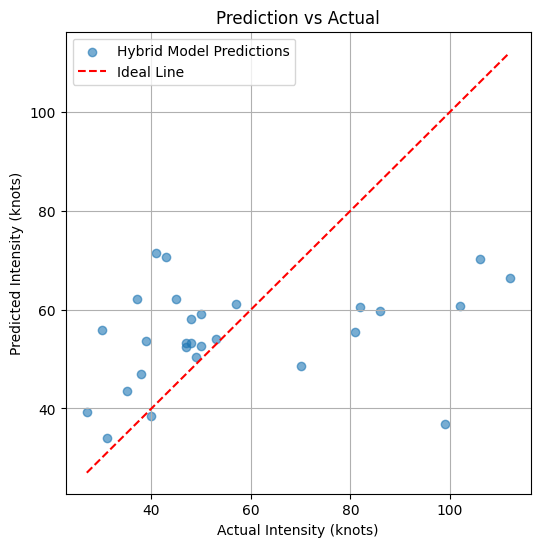

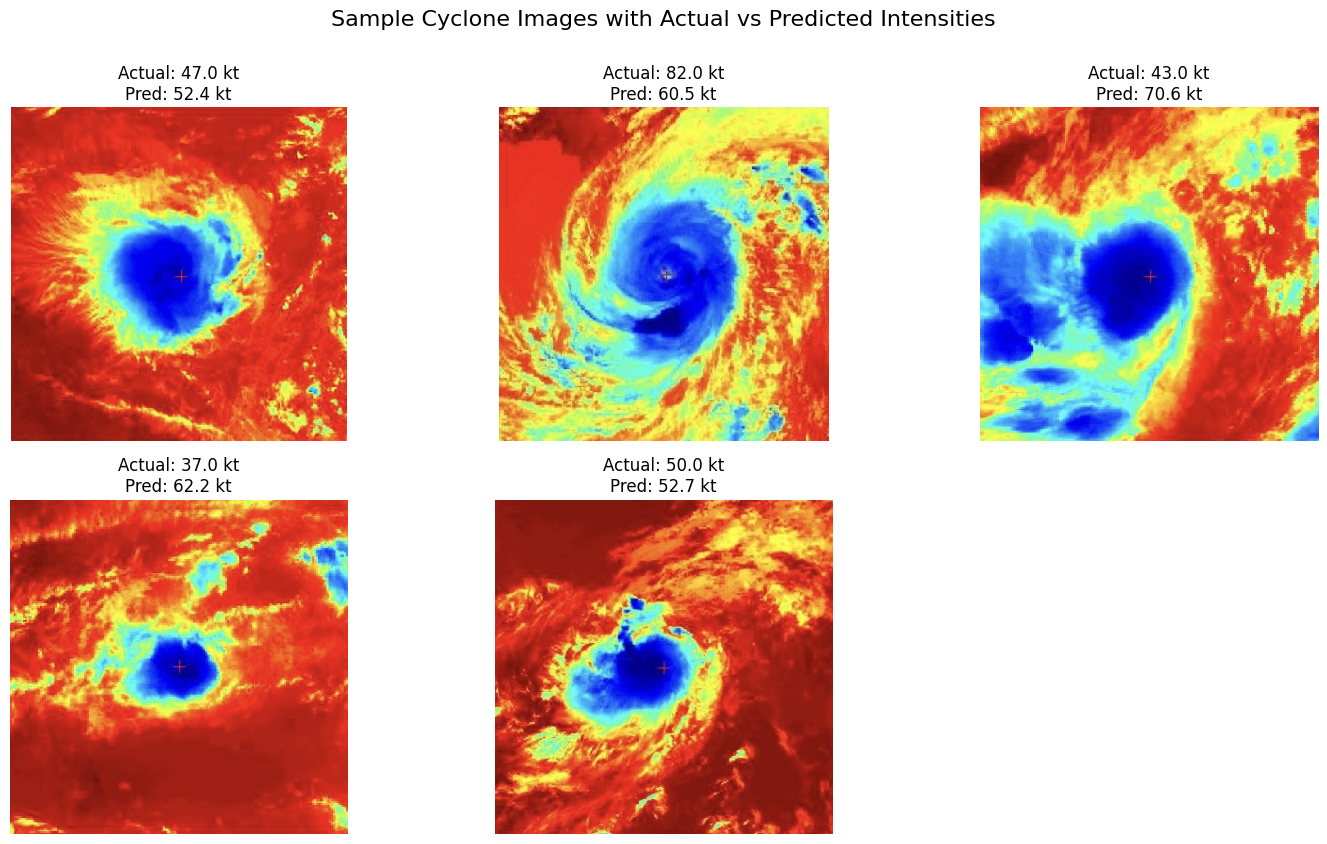

In [ ]:
# Hybrid Cyclone Intensity Prediction Model (Enhanced ViT + 7 Extra Features)

# --- Imports ---
import cv2
import torch
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

from transformers import ViTModel, ViTImageProcessor

# --- Load CSV ---
df = pd.read_csv("/content/insat_3d_ds - Sheet.csv")

def get_label_from_csv(image_name):
    label = df[df['img_name'] == image_name]['label'].values
    return float(label[0]) if len(label) > 0 else 0.0

# --- Load ViT Model ---
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

def extract_vit_features(image_pil):
    inputs = vit_processor(image_pil, return_tensors="pt")
    outputs = vit_model(**inputs)
    return outputs.pooler_output.detach().numpy()[0]

# --- Extra Features Functions ---
def compute_optical_flow(prev_img, next_img):
    flow = cv2.calcOpticalFlowFarneback(prev_img, next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return np.mean(np.abs(flow))

def compute_cai(image):
    return np.std(image) / np.mean(image)

def compute_cctv(image):
    return np.max(image) - np.min(image)

def compute_extra_features(image):
    image = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cai = compute_cai(image)
    cctv = compute_cctv(image)
    flow = compute_optical_flow(gray, gray)
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    max_intensity = np.max(gray)
    flipped = cv2.flip(gray, 1)
    symmetry_score = np.mean(np.abs(gray - flipped))
    return [cai, cctv, flow, mean_intensity, std_intensity, max_intensity, symmetry_score]

# --- Image loading ---
image_folder = "/content/drive/MyDrive/insat3d_ir_cyclone_ds/CYCLONE_DATASET_INFRARED"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

vit_features_list = []
extra_features_list = []
labels = []
valid_image_files = []

for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)
    if image is None:
        continue
    image = cv2.resize(image, (224, 224)).astype('float32') / 255.0
    image_pil = Image.fromarray(cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    vit_feat = extract_vit_features(image_pil)
    extra_feat = compute_extra_features(image)
    label = get_label_from_csv(img_file)

    vit_features_list.append(vit_feat)
    extra_features_list.append(extra_feat)
    labels.append(label)
    valid_image_files.append(img_file)  # Track aligned image filenames

# --- Convert to numpy arrays ---
X_vit = np.array(vit_features_list)
X_extra = np.array(extra_features_list)
y = np.array(labels)

# --- PCA for ViT features ---
pca = PCA(n_components=0.95)
X_vit = pca.fit_transform(X_vit)

# --- Normalize Extra Features and Labels ---
scaler_extra = StandardScaler()
X_extra = scaler_extra.fit_transform(X_extra)

scaler_label = StandardScaler()
y_scaled = scaler_label.fit_transform(y.reshape(-1, 1)).flatten()

# --- Train-test split ---
x1_train, x1_test, x2_train, x2_test, y_train, y_test, img_train, img_test = train_test_split(
    X_vit, X_extra, y_scaled, valid_image_files, test_size=0.2, random_state=42
)

# --- Build Model ---
vit_input = Input(shape=(X_vit.shape[1],), name="vit_input")
x1 = Dense(256, activation='relu')(vit_input)
x1 = Dropout(0.3)(x1)
x1 = BatchNormalization()(x1)

extra_input = Input(shape=(7,), name="extra_input")
x2 = Dense(64, activation='relu')(extra_input)
x2 = Dropout(0.2)(x2)

merged = Concatenate()([x1, x2])
res = Dense(128, activation='relu')(merged)
res = Dropout(0.3)(res)
res_out = Add()([res, Dense(128)(merged)])
x = Dense(64, activation='relu')(res_out)
x = Dropout(0.2)(x)
output = Dense(1)(x)

model = Model(inputs=[vit_input, extra_input], outputs=output)
model.compile(optimizer=Adam(1e-4), loss=Huber(), metrics=['mae'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, verbose=1)

# --- Train ---
model.fit(
    {"vit_input": x1_train, "extra_input": x2_train},
    y_train,
    validation_data=({"vit_input": x1_test, "extra_input": x2_test}, y_test),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler]
)

# --- Predict ---
y_pred_scaled = model.predict({"vit_input": x1_test, "extra_input": x2_test}).flatten()
y_test_inv = scaler_label.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_label.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# --- Evaluation ---
def evaluate_preds(preds, name):
    print(f"\n{name} Evaluation")
    print(f"MSE: {mean_squared_error(y_test_inv, preds):.4f}")
    print(f"MAE: {mean_absolute_error(y_test_inv, preds):.4f}")
    print(f"R^2 Score: {r2_score(y_test_inv, preds):.4f}")

evaluate_preds(y_pred_inv, "Hybrid ViT + 7 Extra Features (Enhanced)")

# --- Plotting ---
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, label='Hybrid Model Predictions')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], '--', color='red', label='Ideal Line')
plt.xlabel("Actual Intensity (knots)")
plt.ylabel("Predicted Intensity (knots)")
plt.title("Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# --- Image Output ---
import random
plt.figure(figsize=(15, 8))
sample_indices = random.sample(range(len(img_test)), 5)

for i, idx in enumerate(sample_indices):
    img_path = os.path.join(image_folder, img_test[idx])
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i+1)
    plt.imshow(image_rgb)
    plt.axis('off')

    actual = y_test_inv[idx]
    predicted = y_pred_inv[idx]

    plt.title(f"Actual: {actual:.1f} kt\nPred: {predicted:.1f} kt")

plt.tight_layout()
plt.suptitle("Sample Cyclone Images with Actual vs Predicted Intensities", fontsize=16, y=1.05)
plt.show()


In [ ]:
# --- Evaluation ---
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score,
    max_error, median_absolute_error
)
import numpy as np

def evaluate_preds(preds, name):
    mse = mean_squared_error(y_test_inv, preds)
    mae = mean_absolute_error(y_test_inv, preds)
    r2 = r2_score(y_test_inv, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, preds) * 100
    evs = explained_variance_score(y_test_inv, preds)
    max_err = max_error(y_test_inv, preds)
    medae = median_absolute_error(y_test_inv, preds)

    print(f"\n📊 {name} Evaluation Metrics")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Explained Variance Score: {evs:.4f}")
    print(f"Max Error: {max_err:.2f}")
    print(f"Median Absolute Error: {medae:.4f}")

evaluate_preds(y_pred_inv, "Hybrid ViT + 7 Extra Features (Enhanced)")



📊 Hybrid ViT + 7 Extra Features (Enhanced) Evaluation Metrics
MSE: 546.8332
MAE: 17.8716
R^2 Score: 0.0845
RMSE: 23.3845
MAPE: 30.91%
Explained Variance Score: 0.0926
Max Error: 62.08
Median Absolute Error: 13.4694


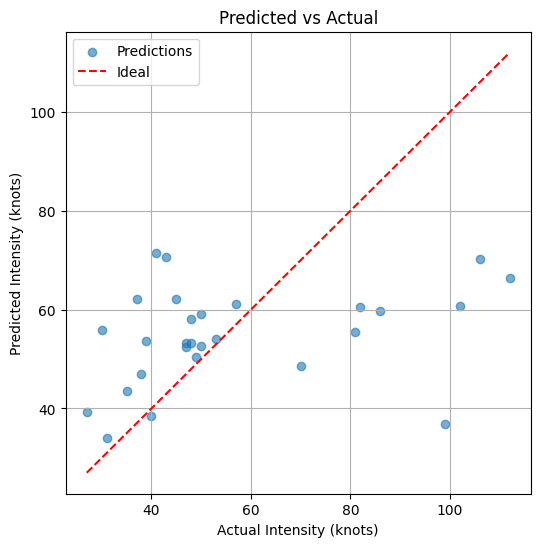

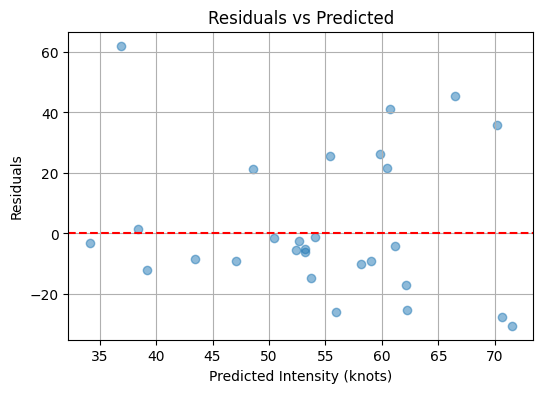

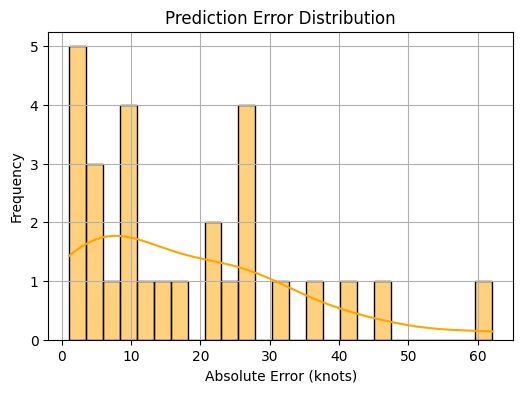

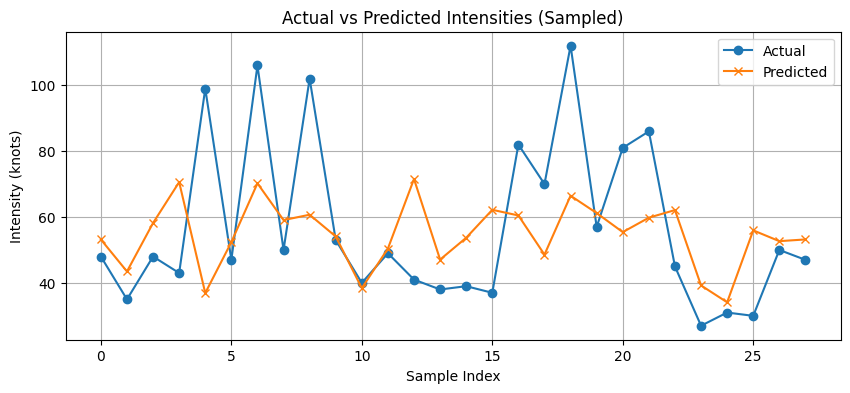

<ipython-input-4-6ee27fc1b014>:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Actual', 'Predicted'])


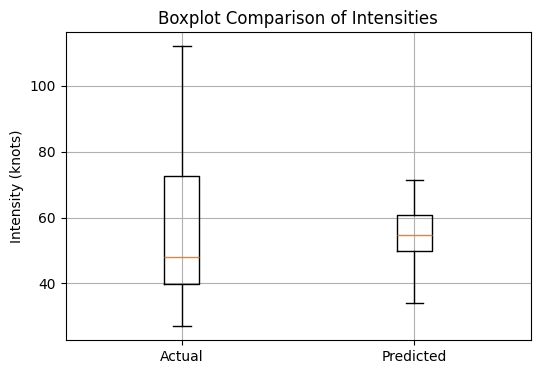

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Residuals
residuals = y_test_inv - y_pred_inv
errors = np.abs(residuals)

# 1. Predicted vs Actual Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.6, label='Predictions')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], '--', color='red', label='Ideal')
plt.xlabel("Actual Intensity (knots)")
plt.ylabel("Predicted Intensity (knots)")
plt.title("Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# 2. Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_inv, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Intensity (knots)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

# 3. Error Distribution Histogram
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=25, kde=True, color='orange')
plt.title("Prediction Error Distribution")
plt.xlabel("Absolute Error (knots)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Actual vs Predicted Line Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv[:100], label='Actual', marker='o')
plt.plot(y_pred_inv[:100], label='Predicted', marker='x')
plt.title("Actual vs Predicted Intensities (Sampled)")
plt.xlabel("Sample Index")
plt.ylabel("Intensity (knots)")
plt.legend()
plt.grid(True)
plt.show()

# 5. Boxplots of Actual vs Predicted
plt.figure(figsize=(6, 4))
data_to_plot = [y_test_inv, y_pred_inv]
plt.boxplot(data_to_plot, labels=['Actual', 'Predicted'])
plt.title("Boxplot Comparison of Intensities")
plt.ylabel("Intensity (knots)")
plt.grid(True)
plt.show()


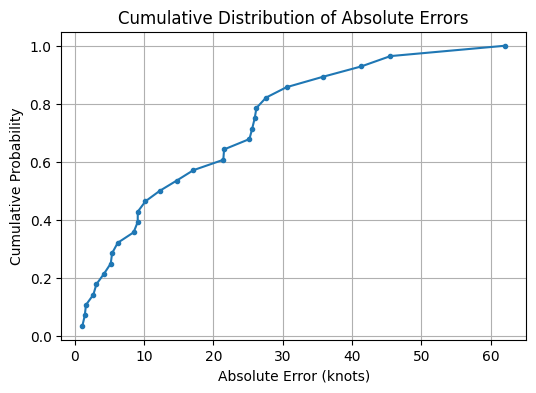

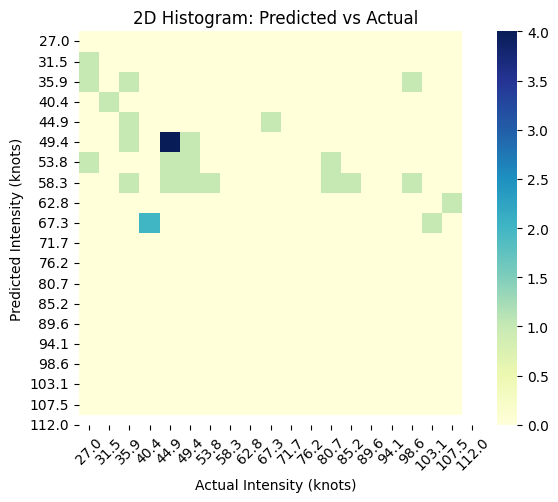

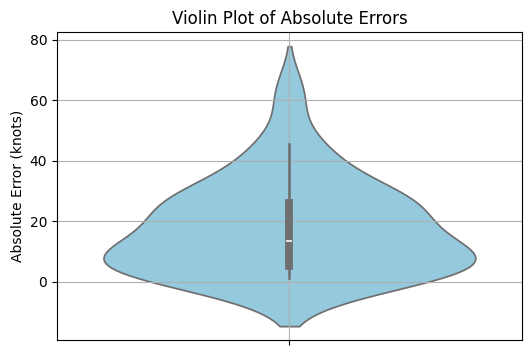

<ipython-input-5-d79512794f87>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=binned_df, x='bin', y='error', palette='pastel')


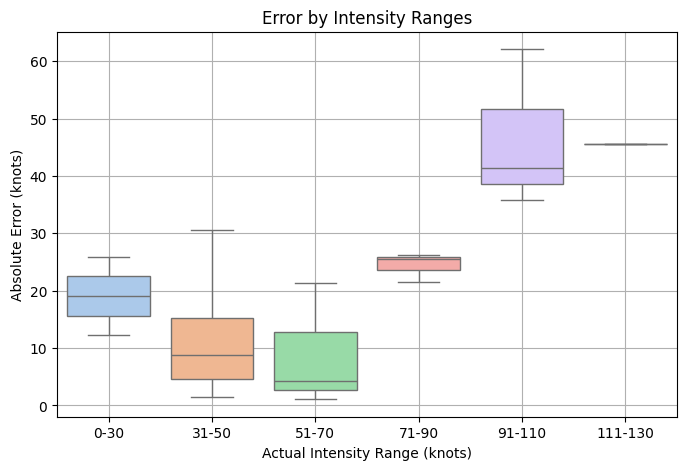

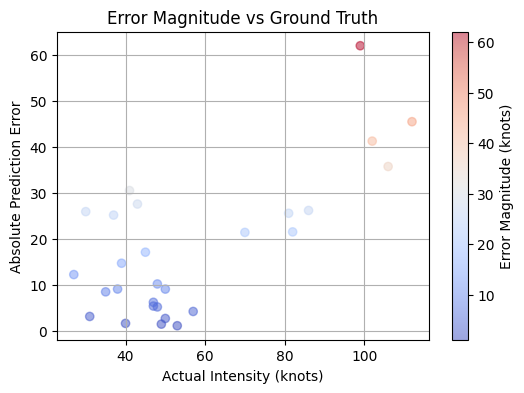

In [ ]:
# 6. Cumulative Distribution of Absolute Errors
plt.figure(figsize=(6, 4))
sorted_errors = np.sort(errors)
cum_prob = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
plt.plot(sorted_errors, cum_prob, marker='.')
plt.xlabel("Absolute Error (knots)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of Absolute Errors")
plt.grid(True)
plt.show()

# 7. Heatmap of Predicted vs Actual (Binned)
bins = np.linspace(min(y_test_inv), max(y_test_inv), 20)
heatmap_data, xedges, yedges = np.histogram2d(y_test_inv, y_pred_inv, bins=[bins, bins])

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data.T, xticklabels=np.round(xedges, 1), yticklabels=np.round(yedges, 1), cmap="YlGnBu", square=True)
plt.xlabel("Actual Intensity (knots)")
plt.ylabel("Predicted Intensity (knots)")
plt.title("2D Histogram: Predicted vs Actual")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8. Violin Plot of Error Distribution
plt.figure(figsize=(6, 4))
sns.violinplot(y=errors, color='skyblue')
plt.title("Violin Plot of Absolute Errors")
plt.ylabel("Absolute Error (knots)")
plt.grid(True)
plt.show()

# 9. Intensity-wise Prediction Error Boxplot
bins = pd.cut(y_test_inv, bins=[0, 30, 50, 70, 90, 110, 130], labels=['0-30','31-50','51-70','71-90','91-110','111-130'])
binned_df = pd.DataFrame({'actual': y_test_inv, 'predicted': y_pred_inv, 'bin': bins})
binned_df['error'] = np.abs(binned_df['actual'] - binned_df['predicted'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=binned_df, x='bin', y='error', palette='pastel')
plt.xlabel("Actual Intensity Range (knots)")
plt.ylabel("Absolute Error (knots)")
plt.title("Error by Intensity Ranges")
plt.grid(True)
plt.show()

# 10. Predicted Error Trend vs Ground Truth Intensity
plt.figure(figsize=(6, 4))
plt.scatter(y_test_inv, errors, alpha=0.5, c=errors, cmap='coolwarm')
plt.colorbar(label='Error Magnitude (knots)')
plt.xlabel("Actual Intensity (knots)")
plt.ylabel("Absolute Prediction Error")
plt.title("Error Magnitude vs Ground Truth")
plt.grid(True)
plt.show()


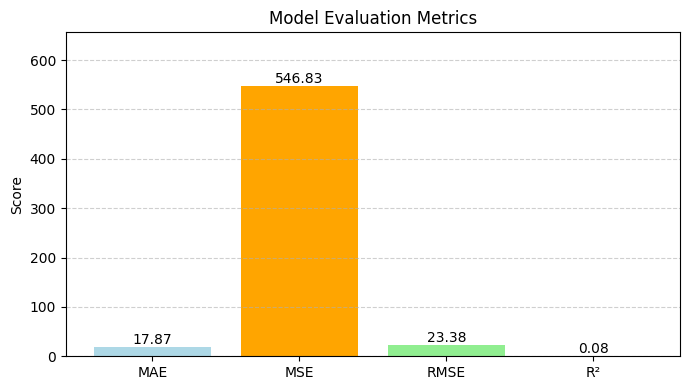

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# --- Evaluation Metrics ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# --- Metric Names & Values ---
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
values = [mae, mse, rmse, r2]

# --- Bar Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(metrics, values, color=['lightblue', 'orange', 'lightgreen', 'salmon'])
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
plt.ylim(0, max(values)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
